# Resolución

En este segundo ejemplo se utiliza el mismo dataset Iris, pero se realizó una limpieza de imágenes para que todas las clases cuenten con una cantidad similar de imágenes (90 por clase). El objetivo es evaluar cómo el balance entre clases influye en el entrenamiento y en la precisión del modelo, reduciendo el sesgo observado en el experimento anterior y promoviendo una aprendizaje más equitativo entre las categorías.

In [1]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Rescaling, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

2025-11-04 20:21:13.290387: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-04 20:21:13.347640: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-04 20:21:14.764674: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:
# Rutas
data_dir = "./Datasets/Iris"
csv_path = os.path.join(data_dir, "iris.csv")
img_dir = os.path.join(data_dir, "images")

# Leer el CSV
df = pd.read_csv(csv_path)

# Si las clases son texto, convertirlas a números (0,1,2)
class_names = sorted(df["class"].unique())
class_to_index = {name: i for i, name in enumerate(class_names)}
df["label"] = df["class"].map(class_to_index)


print("Clases detectadas:", class_to_index)

Clases detectadas: {'setosa': 0, 'versicolour': 1, 'virginica': 2}


In [3]:

# Dividir en entrenamiento (80%) y validación (20%)
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

# Función para cargar una imagen desde su ruta y etiqueta
def load_image(image_name, label):
    img_path = tf.strings.join([img_dir, "/", image_name])
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [128, 128])
    return img, label

In [ ]:
# Crear datasets de TensorFlow

# Convierte las columnas (file_name y label) del dataset en un objeto tf.data.Dataset para entrenar de forma eficiente
train_ds = tf.data.Dataset.from_tensor_slices((train_df["image"].values, train_df["label"].values))
val_ds = tf.data.Dataset.from_tensor_slices((val_df["image"].values, val_df["label"].values))

# Mapear la función de carga de imágenes a los datasets
train_ds = train_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

2025-11-04 20:21:15.825888: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [5]:
# Normalización y aumento
normalization_layer = tf.keras.layers.Rescaling(1./255)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1)
])

# Aplicar aumento y normalización
train_ds = train_ds.map(lambda x, y: (data_augmentation(normalization_layer(x)), y),
                        num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y),
                    num_parallel_calls=tf.data.AUTOTUNE)

# Configurar rendimiento
train_ds = train_ds.shuffle(500).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [6]:

# Modelo convolucional
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(len(class_names), activation='softmax')  # número de clases automático
])

/home/erich/Analista en Computación/Inteligencia Artificial/Practicos-IA/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
# Compilación
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamiento
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop]
)

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step - accuracy: 0.3657 - loss: 1.1278 - val_accuracy: 0.3333 - val_loss: 1.1799
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - accuracy: 0.4630 - loss: 1.0732 - val_accuracy: 0.3333 - val_loss: 1.2100
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.3843 - loss: 1.0639 - val_accuracy: 0.3333 - val_loss: 1.1876
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - accuracy: 0.4815 - loss: 1.0494 - val_accuracy: 0.4630 - val_loss: 1.1389
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.5093 - loss: 1.0330 - val_accuracy: 0.3889 - val_loss: 1.1001
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - accuracy: 0.5139 - loss: 1.0209 - val_accuracy: 0.4074 - val_loss: 1.1103
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.5185 - loss: 1.0213 - val_accuracy: 0.4074 - val_loss: 1.1279
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.4907 - loss: 1.0196 - val_accuracy: 0.4074 - val_loss:

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3889 - loss: 1.1001

🔹 Resultados finales:
Pérdida (loss): 1.1001
Precisión (accuracy): 0.3889


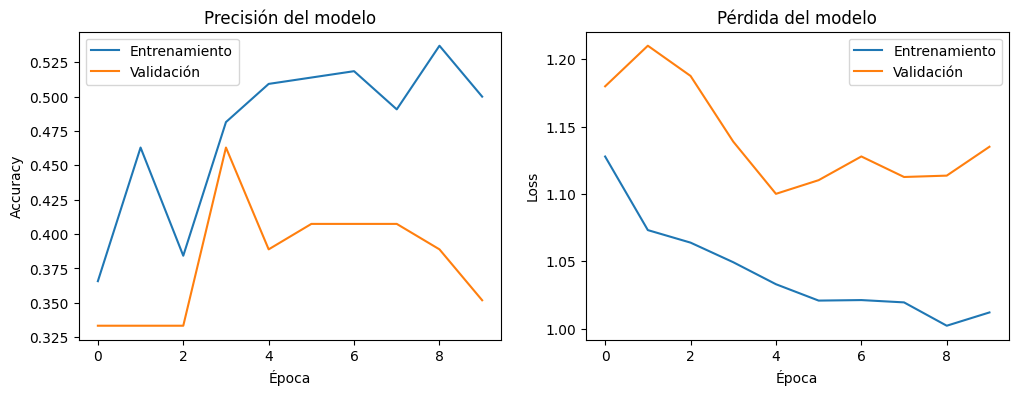

In [8]:
# Evaluación
results = model.evaluate(val_ds)
print("\n🔹 Resultados finales:")
print(f"Pérdida (loss): {results[0]:.4f}")
print(f"Precisión (accuracy): {results[1]:.4f}")

# Gráficos
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Conclusión

A pesar de haber eliminado el desbalance de clases, el modelo obtuvo un accuracy de validación menor (0.4). Este resultado puede explicarse por la reducción del número de imágenes, lo cual limita la capacidad del modelo para aprender patrones. Si bien el dataset ahora es más justo en términos de distribución, la cantidad total de datos es insuficiente para un aprendizaje efectivo. En conclusión, este experimento evidencia que no solo importa el equilibrio entre clases, sino también la cantidad total de ejemplos: un dataset pequeño, aunque balanceado, puede no ser suficiente para obtener buenos resultados.